# NN Shape Analysis - VAD

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats

sns.set_style(rc={'figure.figsize':(3.25,1), 'font.family':"Times New Roman",
                                  'font.size': 8, 'dpi': 300})

plots = "/home/djanke3/Documents/Spyder/plots/"

In [30]:
with open("NetworkShapeAnalysis_CompTanh.json", 'r') as nsa:
    data = json.load(nsa)
print(len(data))
#with open("NetworkShapeAnalysis_grid_Tanh1.json", 'r') as nsa:
#    data.update(json.load(nsa))

acc_lim = [70, 85]
iqr_lim = [2, 15]

def str_to_list(in_string):
    temp = in_string[1:-1].split(',')
    return [int(s) for s in temp]

score_num = 0
for t,d in data.items():
    if type(d) is int: continue
    d["shape"] = str_to_list(d["shape"])
    d["hidden"] = len(d["shape"]) - 2
    acc = d["accs"]
    scores = (list(acc.values()))
    scores = np.vstack([np.array(s) for s in scores])[score_num]
    d["medians"] = np.median(scores) * 100
    d["iqr"] = (np.quantile(scores, 0.75) - np.quantile(scores, 0.25)) * 100
    #for i in range(d["hidden"]):
    #    d["shrink"] = d.get("shrink", 1) * (d["shape"][i] / d["shape"][i + 1]) ** (d["hidden"] + 1 - i)
    #d['loc'], d['spread'] = stats.gumbel_r.fit(scores)
    d["u75"] = scores.max() - np.quantile(scores, 0.25)
    d["synapses"] = sum([n * d["shape"][i + 1] for i,n in enumerate(d["shape"][:-1])])
    #print(d)
    #input()
    

1000


In [31]:
df = pd.DataFrame.from_dict(data, orient = "index")
#print(df.head())
print(df["hidden"].value_counts())
if "computer" in df.columns:
    df.drop(["computer"], axis = 1, inplace = True)
    df.dropna(how = "all", inplace = True)
#df.head()

4    625
3    125
2    125
1    125
Name: hidden, dtype: int64


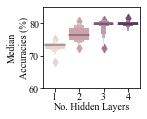

In [32]:
# Plot median accuracy vs num hidden layers
fig = plt.figure()
fig.set_figheight(1.5)
fig.set_figwidth(1.75)
plt0 = sns.boxenplot(x = "hidden", y = "medians", data = df, palette = sns.cubehelix_palette(4, dark=0.35))
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel("Median\nAccuracies (%)", labelpad = 0)
plt.xlabel("No. Hidden Layers", labelpad=0)
plt.ylim([60,85])

plt0.tick_params(axis='both', which='major', pad=0)
fig = plt0.get_figure()
figname = plots + "VAD_CompTanh_median.pdf"
fig.savefig(figname, dpi=300, bbox_inches='tight')
#plt.show()

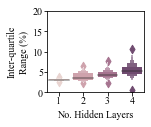

In [33]:
# Plot accuracy IQR vs num hidden layers
fig = plt.figure()
fig.set_figheight(1.5)
fig.set_figwidth(1.75)
plt0 = sns.boxenplot(x = "hidden", y = "iqr", data = df, palette = sns.cubehelix_palette(4, dark=0.35))
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel("Inter-quartile\nRange (%)")
plt.xlabel("No. Hidden Layers")
plt.ylim([0,20])

plt0.tick_params(axis='both', which='major', pad=0)
fig = plt0.get_figure()
figname = plots + "VAD_CompTanh_iqr.pdf"
fig.savefig(figname, dpi=300, bbox_inches='tight')
#plt.show()

In [6]:
def get_nodes_synapses(row):
    shape = row["shape"]
    if type(shape) is float: print(row)
    nodes = pd.Series([None] * (6 - len(shape)) + shape[1:-1], dtype = 'float32')
    nodes.index = ["n{}".format(i) for i in range(4)]
    synapses = {"s{}".format(i) : (shape[i - 6] + 1) * shape[i - 5] for i in range(5) if i - 6 >= -len(shape)}
    synapses = pd.Series(synapses, dtype = "int16")
    nodes_synapses = pd.concat([nodes,synapses])
    
    return nodes_synapses

def get_nodes(row):
    shape = row["shape"]
    if type(shape) is float: print(row)
    nodes = pd.Series(shape[1:-1] + [0] * (6 - len(shape)), dtype = 'int16')
    ratios = pd.Series([n/shape[i+2] for i,n in enumerate(shape[1:-2])] + [0] * (6 - len(shape)), dtype = 'float32')
    ratio_bool = (ratios.fillna(0) + 1) // 2 #.astype(int)
    ratio_bool[ratio_bool == 3] = 2
    nodes.index = ["N{}".format(i) for i in range(4)]
    ratios.index = ["N{}/N{}".format(i,i+1) for i in range(3)]
    ratio_bool.index = [i+"Bool" for i in ratios.index]
    
    return nodes.append(ratios).append(ratio_bool)

'''
def convolve_synapses(df):
    temp = df[["s0", "s1", "s2", "s3", "s4"]]
    cols = list(temp.columns)[::-1]
    for i in range(1,len(cols)):
        temp.loc[:,cols[i]] = temp[cols[i-1]].dropna() + temp[cols[i]]
    temp.columns = ["c{}".format(i) for i in range(5)]
    return temp
'''

nodes_and_synapses = df.apply(get_nodes, axis = 1)
shape_df = df.drop(["accs"], axis = 1).merge(nodes_and_synapses, how = "left",
                                                    left_index  = True, right_index = True)
#shape_df = shape_df.merge(convolve_synapses(shape_df), how = "left",
#                          left_index  = True, right_index = True)
shape_df.loc[:, ["N0", "N1", "N2", "N3"]] = shape_df.loc[:, ["N0", "N1", "N2", "N3"]].astype(int)
shape_df.head(10)

,shape,f1s,max_weight,hidden,medians,iqr,u75,synapses,N0,N1,N2,N3,N0/N1,N1/N2,N2/N3,N0/N1Bool,N1/N2Bool,N2/N3Bool
"trial(12, 3, 1)0","[12, 3, 1]","{'train': [0.7589809108672778, 0.7634372555592...",4.850986,1,72.000867,2.736545,0.073448,39,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
"trial(12, 3, 1)1","[12, 3, 1]","{'train': [0.7574835680751174, 0.7254063301967...",4.676394,1,71.759984,2.613932,0.069412,39,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
"trial(12, 3, 1)2","[12, 3, 1]","{'train': [0.747333130143249, 0.76053697315134...",4.688903,1,72.144097,2.783202,0.075640,39,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
"trial(12, 3, 1)3","[12, 3, 1]","{'train': [0.7462732207017811, 0.7349996118916...",4.895333,1,72.163630,2.687716,0.070931,39,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
"trial(12, 3, 1)4","[12, 3, 1]","{'train': [0.7471124620060791, 0.7666691611165...",4.990815,1,72.328562,2.809241,0.067665,39,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
"trial(12, 3, 1)5","[12, 3, 1]","{'train': [0.7531037624814914, 0.7528000905079...",5.190979,1,72.013891,2.750655,0.079742,39,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
"trial(12, 3, 1)6","[12, 3, 1]","{'train': [0.7558830163145628, 0.7381888246628...",4.664680,1,72.105038,2.532555,0.075184,39,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
"trial(12, 3, 1)7","[12, 3, 1]","{'train': [0.7452937173962351, 0.7063371861299...",3.519781,1,68.077260,3.152126,0.075879,39,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
"trial(12, 3, 1)8","[12, 3, 1]","{'train': [0.7585687382297552, 0.7318153559216...",4.897142,1,72.102869,2.658421,0.071452,39,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
"trial(12, 3, 1)9","[12, 3, 1]","{'train': [0.7552484518954841, 0.7552144675354...",4.634853,1,71.412763,2.856988,0.083952,39,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
yvars = ["medians", "iqr", "u75"]
ylabels = ["Median\nAccuracy (%)", "Inter-quartile\nRange (%)", "Upper 3QR"]

xvars = ["synapses", "N0", "N1", "N2", "N3", "N0/N1", "N1/N2", "N2/N3"]
xlabels = ["Total No. Synapses",
          "Synapses in Hidden Layer 0", "Synapses in Hidden Layer 1",
          "synapses in Hidden Layer 2", "synapses in Hidden Layer 3",
          "N0/N1 Ratio", "N1/N2 Ratio", "N2/N3 Ratio"]

def plot_accuracies(x_num, y_num, hue, hl, sub_data = None, hue_start = 0):
    
    fig = plt.figure()
    fig.set_figheight(1.5)
    fig.set_figwidth(3.5)
    
    yvar = yvars[y_num]
    ylabel = ylabels[y_num]
    ylim = [acc_lim, iqr_lim][y_num]
    
    xvar = xvars[x_num]
    xlabel = xlabels[x_num]
    swarm = x_num != 0 and x_num < 5
    
    data = shape_df[shape_df["hidden"] == hl]
    if sub_data:
        data = data[data[sub_data[0]] == sub_data[1]]
    unique = len(data[hue].value_counts())
    if swarm:
        #title = hue
        plt0 = sns.swarmplot(x = xvar, y = yvar, hue = hue, data = data,
                             palette = sns.cubehelix_palette(unique, start = hue_start),
                             dodge = True, **{"marker":'o'})
    else:
        #title = None
        if '/' in hue: legend = "brief"
        else: legend = "full"
        plt0 = sns.scatterplot(x = xvar, y = yvar, hue = hue, data = data, legend = legend,
                              palette = sns.cubehelix_palette(unique, start = hue_start))
            
    title = None
    
    if y_num == 0 : location = "lower right"
    else: location = "upper right"
    if "Bool" in hue:
        palette = sns.cubehelix_palette(unique, start = hue_start)
        title = mpatches.Patch(color='white', label=hue[:-4])
        less = plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=palette[0], label='r$<$1')
        mid = plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=palette[1], label='$1\leq$r$<$3')
        more = plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=palette[2], label='$3\leq$r$\leq$5')
        
        lgd = plt.legend(title = None, ncol = 2, handles=[title, less, mid, more], loc=location,
                         borderaxespad=0., fancybox = False, edgecolor = 'black',
                         handlelength = 0.5, handletextpad = 0.5, columnspacing = 0.5)
    else:
        lgd = plt.legend(ncol = 3, loc=location,
                         borderaxespad=0., fancybox = False, edgecolor = 'black',
                         handlelength = 0.5, handletextpad = 0.5, columnspacing = 0.5)
    
    #plt.xticks(rotation=20)
    plt.yticks([y for y in range(ylim[0], ylim[1] + 1) if y % 5 == 0])
    plt.grid(True,axis = 'y')
    
        
    plt.ylabel(ylabel, labelpad = 0)
    plt.xlabel(xlabel, labelpad = 0)
    plt.ylim(ylim)
    plt0.tick_params(axis='both', which='major', pad=0)
    #fig.tight_layout()
    
    hue = ''.join(hue.split('/'))
    xvar = ''.join(xvar.split('/'))
    fig = plt0.get_figure()
    figname = plots + "VAD_hl{}_x{}_y{}_h{}.pdf".format(hl, xvar, yvar, hue)
    fig.savefig(figname, dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))
    #plt.show()

## Plot as a function of nodes in first layer
Hue is the number of nodes in first layer divided by nodes in second layer

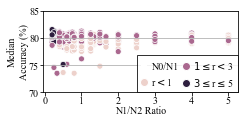

In [8]:
# 4hl, medians, hue = n0n1

x_num = 6
hue = "N0/N1Bool"

y_num = 0
hl = 4

plot_accuracies(x_num, y_num, hue, hl)

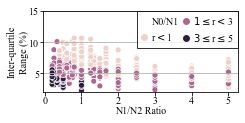

In [9]:
# 4hl, medians, hue = n0n1

x_num = 6
hue = "N0/N1Bool"

y_num = 1
hl = 4

plot_accuracies(x_num, y_num, hue, hl)

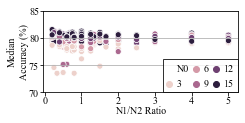

In [10]:
# 4hl, medians, hue = n0n1

x_num = 6
hue = "N0"

y_num = 0
hl = 4

plot_accuracies(x_num, y_num, hue, hl)

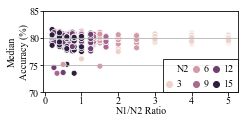

In [11]:
# 4hl, medians, hue = n0n1

x_num = 6
hue = "N2"

y_num = 0
hl = 4

plot_accuracies(x_num, y_num, hue, hl)

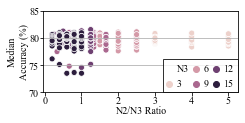

In [12]:
# 4hl, medians, hue = n0n1

x_num = 7
hue = "N3"

y_num = 0
hl = 4

plot_accuracies(x_num, y_num, hue, hl)

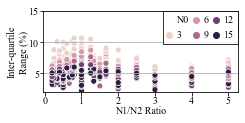

In [13]:
# 4hl, iqr, hue = n0n1

x_num = 6
hue = "N0"

y_num = 1
hl = 4

plot_accuracies(x_num, y_num, hue, hl)

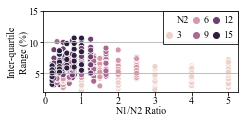

In [14]:
# 4hl, iqr, hue = n0n1

x_num = 6
hue = "N2"

y_num = 1
hl = 4

plot_accuracies(x_num, y_num, hue, hl)

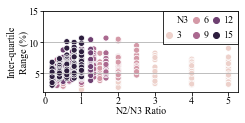

In [15]:
# 4hl, iqr, hue = n0n1

x_num = 7
hue = "N3"

y_num = 1
hl = 4

plot_accuracies(x_num, y_num, hue, hl)

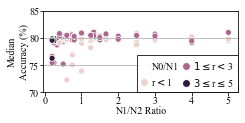

In [16]:
# 3hl, acc, hue = n0n1

x_num = 6
hue = "N0/N1Bool"

y_num = 0
hl = 3

plot_accuracies(x_num, y_num, hue, hl)

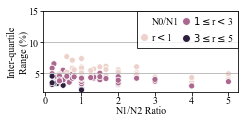

In [17]:
# 3hl, iqr, hue = n0n1

x_num = 6
hue = "N0/N1Bool"

y_num = 1
hl = 3

plot_accuracies(x_num, y_num, hue, hl)

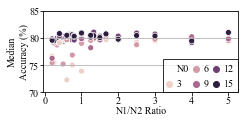

In [18]:
# 3hl, medians, hue = n0n1

x_num = 6
hue = "N0"

y_num = 0
hl = 3

plot_accuracies(x_num, y_num, hue, hl, hue_start = 0)

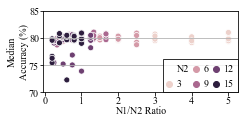

In [19]:
# 3hl, medians, hue = n0n1

x_num = 6
hue = "N2"

y_num = 0
hl = 3

plot_accuracies(x_num, y_num, hue, hl, hue_start = 0)

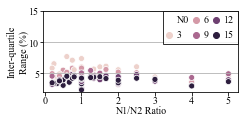

In [20]:
# 3hl, iqr, hue = n0n1

x_num = 6
hue = "N0"

y_num = 1
hl = 3

plot_accuracies(x_num, y_num, hue, hl)

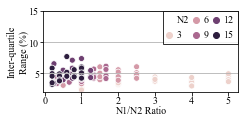

In [21]:
# 3hl, iqr, hue = n0n1

x_num = 6
hue = "N2"

y_num = 1
hl = 3

plot_accuracies(x_num, y_num, hue, hl)

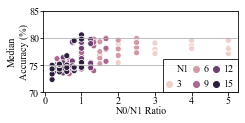

In [22]:
# 2hl, medians, hue = n0n1

x_num = 5
hue = "N1"

y_num = 0
hl = 2

plot_accuracies(x_num, y_num, hue, hl)

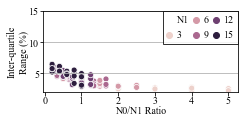

In [23]:
# 2hl, iqr, hue = n0n1

x_num = 5
hue = "N1"

y_num = 1
hl = 2

plot_accuracies(x_num, y_num, hue, hl)